In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_moons

np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.set_floatx('float64')

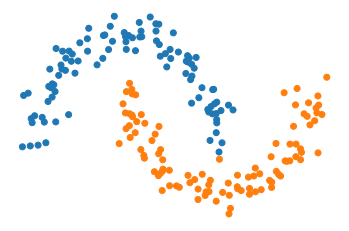

In [12]:
# Creating the data set
X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y,num_classes=2)
c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]

plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [13]:
# Creating a Quantum NOde (to insert as a layer)
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    # Convert from classical input to Angles on the Bloch Sphere
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits)) 

    # Entangle the input features togehter
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 

    # Return the expected value, after using the PauliZ operator to flip matrix 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)] 

In [14]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)} # Expected input for Keras Q Layer

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Simple Hybrid Model
![](qnn_keras.png)

In [15]:
# Creating a simple hybrid model
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")

model = tf.keras.Sequential([clayer_1, qlayer, clayer_2])
opt = tf.keras.optimizers.SGD(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])

In [19]:
model.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/6
30/30 - 7s - loss: 0.4857 - accuracy: 0.5467 - val_loss: 0.5711 - val_accuracy: 0.3600
Epoch 2/6
30/30 - 7s - loss: 0.4675 - accuracy: 0.5467 - val_loss: 0.5575 - val_accuracy: 0.3600
Epoch 3/6
30/30 - 7s - loss: 0.4011 - accuracy: 0.6400 - val_loss: 0.3526 - val_accuracy: 0.7800
Epoch 4/6
30/30 - 7s - loss: 0.2696 - accuracy: 0.8067 - val_loss: 0.1980 - val_accuracy: 0.9000
Epoch 5/6
30/30 - 7s - loss: 0.2212 - accuracy: 0.8467 - val_loss: 0.1463 - val_accuracy: 0.9200
Epoch 6/6
30/30 - 7s - loss: 0.1928 - accuracy: 0.8267 - val_loss: 0.1276 - val_accuracy: 0.8800


# Advanced Hybrid Model
![](qnn2_keras.png)

In [21]:
clayer_1 = tf.keras.layers.Dense(4)
qlayer_1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim= n_qubits)
qlayer_2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim= n_qubits)
clayer_2 = tf.keras.layers.Dense(2, activation="softmax")

inputs = tf.keras.Input(shape=(2,))
x = clayer_1(inputs)
x_1, x_2 = tf.split(x, 2, axis=1)
x_1 = qlayer_1(x_1)
x_2 = qlayer_2(x_2)
x = tf.concat([x_1, x_2], axis=1)
outputs = clayer_2(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.2)
model.compile(opt, loss="mae", metrics=["accuracy"])

history = model.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25, verbose=2)

Epoch 1/6
30/30 - 15s - loss: 0.2426 - accuracy: 0.7667 - val_loss: 0.2502 - val_accuracy: 0.7400
Epoch 2/6
30/30 - 18s - loss: 0.1891 - accuracy: 0.8200 - val_loss: 0.1128 - val_accuracy: 0.9000
Epoch 3/6
30/30 - 15s - loss: 0.2520 - accuracy: 0.7267 - val_loss: 0.2572 - val_accuracy: 0.7600
Epoch 4/6
30/30 - 14s - loss: 0.2403 - accuracy: 0.7867 - val_loss: 0.0955 - val_accuracy: 0.9200
Epoch 5/6
30/30 - 14s - loss: 0.2124 - accuracy: 0.7800 - val_loss: 0.1525 - val_accuracy: 0.8200
Epoch 6/6
30/30 - 14s - loss: 0.0900 - accuracy: 0.9200 - val_loss: 0.0598 - val_accuracy: 0.9600
